In [1]:
import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipykernel_6959/1293129172.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


### Create data

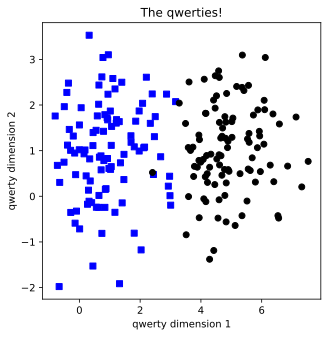

In [2]:
# create data
nPerClust=100
blur=1

A=[1,1]
B=[5,1]

# generate data
a=[A[0]+np.random.randn(nPerClust)*blur, A[1]+np.random.randn(nPerClust)*blur]
b=[B[0]+np.random.randn(nPerClust)*blur, B[1]+np.random.randn(nPerClust)*blur]

# true labels
labels_np=np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concat into matrix
data_np=np.hstack((a,b)).T

# convert to tensor
data=torch.tensor(data_np).float()
labels=torch.tensor(labels_np).float()

# show the data
fig=plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

### Functions to build and train model

In [4]:
def  createANNmodel(learningRate):
    # model architecture
    # build the model
    ANNclassify=nn.Sequential(
        nn.Linear(2,1), # input
        nn.ReLU(), # activation
        nn.Linear(1,1), # output
        # nn.Sigmoid(), # final activation # removing cause BCEewithlogit
    )

    lossfun=nn.BCEWithLogitsLoss()

    optimizer=torch.optim.SGD(ANNclassify.parameters(),lr=learningRate)

    return ANNclassify,lossfun,optimizer

In [5]:
# function that trains

# fixed param
numepochs=1000

def trainTheModel(ANNmodel):
    losses=torch.zeros(numepochs)

    for epochi in range(numepochs):
        # fwd
        yHat=ANNmodel(data)

        loss=lossfun(yHat,labels)
        losses[epochi]=loss

        # bck
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    predictions=ANNmodel(data)

    totalacc=100*torch.mean(((predictions>0)==labels).float())

    return losses,predictions,totalacc

### Test new code once

Final Accuracy: 93.5%


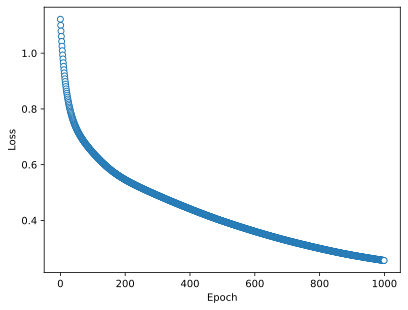

In [7]:
# create everything
ANNclassify,lossfun,optimizer=createANNmodel(.01)

# run it
losses,predictions,totalacc=trainTheModel(ANNclassify)

# report accuracy
print('Final Accuracy: %g%%' %totalacc)

# plot losses
plt.plot(losses.detach(),'o',markerfacecolor='w',linewidth=.1)
plt.xlabel('Epoch'),plt.ylabel('Loss')
plt.show()

### Now for experiment

In [8]:
learningrates=np.linspace(.001,.1,40)

accByLR=[]
allLosses=np.zeros((len(learningrates),numepochs))

for i,lr in enumerate(learningrates):
    ANNclassify,lossfun,optimizer=createANNmodel(lr)
    losses,predictions,totalacc=trainTheModel(ANNclassify)

    accByLR.append(totalacc)
    allLosses[i,:]=losses.detach()

/tmp/ipykernel_6959/3303644412.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  allLosses[i,:]=losses.detach()


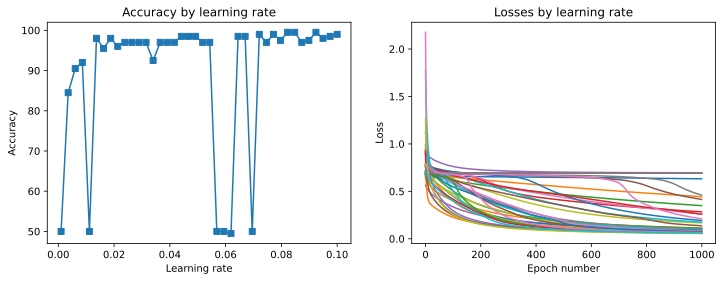

In [10]:
# plot results
fig,ax=plt.subplots(1,2,figsize=(12,4))

ax[0].plot(learningrates,accByLR,'s-')
ax[0].set_xlabel('Learning rate')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy by learning rate')

ax[1].plot(allLosses.T)
ax[1].set_title('Losses by learning rate')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')
plt.show()

In [11]:
# proportion of runs where the model had atleast 70% accuracy
sum(torch.tensor(accByLR)>70)/len(accByLR)

tensor(0.8500)

### Run a meta-experiment to get more reliable results

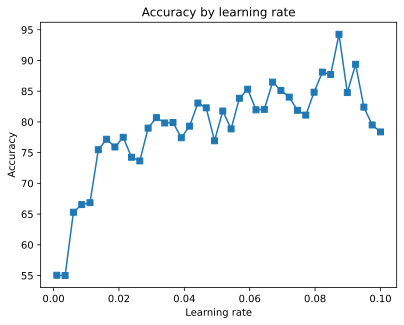

In [13]:
numExps=50

accMeta=np.zeros((numExps,len(learningrates)))

numepochs=500

for expi in range(numExps):
    for i,lr in enumerate(learningrates):
        ANNclassify,lossfun,optimizer=createANNmodel(lr)
        losses,predictions,totalacc=trainTheModel(ANNclassify)

        # accByLR.append(totalacc)
        # allLosses[i,:]=losses.detach()
        accMeta[expi,i]=totalacc

# now plot. averaged over experiments
plt.plot(learningrates,np.mean(accMeta,axis=0),'s-')
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.title('Accuracy by learning rate')
plt.show()